# Reverse engineering of CAD models via clustering and approximate implicitization
### Andrea Raffo, Oliver Barrowclough and Georg Muntingh

This Jupyter notebook contains a Python implementation of the algorithm presented in [1], for extracting primitive geometry underlying point clouds, for instance originating from CAD models, parametric Bézier or spline curves, by combining clustering analysis and approximate implicitization.

The proposed method can recover algebraic hypersurfaces of any degree and is automatic, in the sense that all the required parameters, such as the implicit degree of the patches and the number
of clusters of the model, are inferred. The efficiency of the algorithm is determined from numerical experiments.

[1] A. Raffo, O.J.D. Barrowclough, G. Muntingh, _Reverse engineering of CAD models via clustering and approximate implicitization_, available at https://arxiv.org/abs/1810.07451.

## The algorithm
### Importing libraries and parameters
We import standard Python libraries for numerics, plotting and timing. The algorithm will search for hypersurfaces up to degree `d_max`. The number of sampling points per patch is represented by `ns`.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import sys
import time
import timeit
timeit.default_timer()

d_max = 2
ns    = 10

graphics_path = "./figs/"

### Approximate implicitization

In [2]:
monomial_exponents = [np.array([[i,j] for i in range(d+1) for j in range(d-i+1)], dtype = float) for d in range(1,d_max+1)]
dim_bases = [(d+1)*(d+2) // 2 for d in range(1,d_max+1)]

def approx_implicit(d, segments):
    """
    Given a degree `d`, number of sampling points `n_sample`, and segment matrix `segments`,
    return the singular value `S[-1]` corresponding to the approximate implicit form with
    smallest algebraic error.
    """
    n_sample = segments.shape[1] // 2
    
    # Polynomial basis of the approximate implicit form
    dim_basis = dim_bases[d-1]
    bb = monomial_exponents[d-1]
    
    # Degree approximation
    xx = segments[0,:n_sample].T
    yy = segments[0,n_sample:2*n_sample].T
    if d == 1:
        A = np.concatenate([np.ones((n_sample, 1)), xx, yy], axis = 1)
    elif d == 2:
        A = np.concatenate([np.ones((n_sample, 1)), xx, yy, np.multiply(xx,xx), np.multiply(xx,yy), np.multiply(yy,yy)], axis = 1)
    else:
        A = np.asmatrix(np.ones((n_sample, dim_basis)))
        for kk in range(1, dim_basis):
            if bb[kk,1] == 0:
                A[:,kk] = np.asmatrix(np.power(segments[0,0:n_sample].T, bb[kk,0]))
            elif bb[kk,0] == 0:
                A[:,kk] = np.asmatrix(np.power(segments[0,n_sample:2*n_sample].T, bb[kk,1]))
            else:
                A[:,kk] = np.asmatrix(np.squeeze(np.asarray(np.power(segments[0,0:n_sample].T,bb[kk,0])))*\
                                      np.squeeze(np.asarray(np.power(segments[0,n_sample:2*n_sample].T,bb[kk,1])))).T

    S = np.linalg.svd(A, compute_uv=False)
    return 0, S[-1]

segments_joined = np.matrix([[1.54602091, 1.50307588, 1.46013086, 1.41718583, 1.37424081, 1.33129578, 1.28835076, 1.24540573, 1.20246071,  1.15951568,  0.19603428,  0.19058888, 0.18514349,  0.17969809,  0.17425269,  0.1688073 ,  0.1633619 ,  0.1579165,  0.15247111,  0.14702571,  1.26878657,  1.2335425 ,  1.19829843,  1.16305435, 1.12781028, 1.09256621, 1.05732214, 1.02207807, 0.986834, 0.95158993, -1.99036945, -1.93508141, -1.87979337, -1.82450533, -1.76921729, -1.71392925, -1.65864121, -1.60335317, -1.54806513, -1.49277709]])
%timeit approx_implicit(2, segments_joined)

39.2 µs ± 998 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Calibration and pre-processing
We would like to distinguish the point clouds corresponding to linear segments from conical segments. For this we derive a tolerance `tol1` using the approach in [1, Algorithm 3.3??]. In addition we introduce a tolerance `tol0` to be used in the stopping criterion (deciding the final number of clusters), which is here introduced manually, but can alternatively be computed using [1, Algorithm 3.6??].

In [3]:
def supervised_criterion(ns = 10, NS = 300):
    """    
    Given a number `NS` of segments for each type of conic, each to be sampled
    at `ns` points, return the tolerance `tol1` separating singular values of
    linear segments from those of conical segments.
    """

    # We consider parametric conics as a linear combination of 4 affine types:
    # (1=line, 2=ellipse, 3=hyperbola, 4=parabola)
    f = lambda tau, t: tau[0]*np.matrix([            t,           t]) + \
                       tau[1]*np.matrix([  math.cos(t), math.sin(t)]) + \
                       tau[2]*np.matrix([1/math.cos(t), math.tan(t)]) + \
                       tau[3]*np.matrix([            t,        t**2])

    # We will generate 2*NS segments of type L_seg_type[type - 1].
    L_seg_type = NS*[0] + (NS // 3)*[1] + (NS // 3)*[2] + (NS // 3)*[3]
    
    # Parametric intervals of definitions for the segments of type=1,2,3,4.
    intervals = np.matrix([[-10,10], [0,2*math.pi], [-1.47,1.47], [-3,3]])

    # `theta` is a list of random rotations for each segment
    theta = np.random.rand(1,2*NS)*2*math.pi

    # Matrix containing, for each row, the ns points sampled from a section. The
    # points are stored as follows: the first ns coordinate of each row
    # represent the x-coordinates, while the last ns are the y-coordinates.
    segments = np.asmatrix(np.zeros((1, 2*ns+2)))
    
    # Assemble a matrix `segments` of point clouds of 2*NS segments of random types
    for k in range(2*NS):
        # Sampling of the endpoints of the parametric interval, for each segment
        seg_type = L_seg_type[k]
        sample_interval = intervals[seg_type, 0] + np.asmatrix(np.random.rand(1,2)) *\
                         (intervals[seg_type, 1] - intervals[seg_type, 0])
        
        sample_interval.sort()
        
        # Sampling of `ns` parameters for each parametric interval
        sample = np.linspace(sample_interval[0,0], sample_interval[0,1], num=ns)
        
        # We consider the 1-hot encoding `tau` of the segment type
        tau = [int(i == seg_type) for i in range(4)]
        
        # Sampling of the points for each conic section
        sample_final = np.asmatrix(np.zeros((1, 2*ns+2)))
        for j in range(ns):
            sample_final[0,[j,j+ns]] = f(tau, sample[j])

        # Exact algebraic variety degree is encoded as the penultimate column
        sample_final[:,2*ns] = (seg_type != 0) + 1
    
        # Apply a rotation
        R = np.matrix([[np.cos(theta[0,k]), -np.sin(theta[0,k])],\
                       [np.sin(theta[0,k]),  np.cos(theta[0,k])]])
        
        for i in range(ns):
            sample_final[0,[i,i+ns]] = np.dot(R, sample_final[0,[i,i+ns]].T).T
  
        # Apply a component-wise dilatation and translation
        sample_final[:, 0:  ns] = sample_final[:, 0:  ns] + (np.random.rand(1,1)[0,0]*20 - 10)
        sample_final[:, 0:  ns] = sample_final[:, 0:  ns]*(1/20) # Scale to the interval [-1, 1]
        sample_final[:,ns:2*ns] = sample_final[:,ns:2*ns] + (np.random.rand(1,1)[0,0]*20 - 10)
        sample_final[:,ns:2*ns] = sample_final[:,ns:2*ns]*(1/20) # Scale to the interval [-1, 1]
        segments = np.concatenate((segments,sample_final), axis=0)
    
    segments = segments[1:,:]    
    
    measures_lin = np.array([[approx_implicit(1, segments[i   ,0:2*ns])[1] for i in range(NS)]])
    measures_con = np.array([[approx_implicit(1, segments[i+NS,0:2*ns])[1] for i in range(NS)]])

    # The tolerance is the geometric mean of the average singular values
    # for linear and conical segments.
    tol1 = math.sqrt(np.mean(measures_lin[0])*np.mean(measures_con[0]))
    
    # Alternatively, one can take the geometric mean of the maximum
    # linear singular value and minimum conical singular value.
    #tol1 = math.sqrt(max(measures_lin[0])*min(measures_con[0]))
    return tol1

tol1 = supervised_criterion(ns = ns, NS = 30); print(tol1)

2.4899359177884646e-09


### Assembling and updating dissimilarity matrices
We construct an np.matrix of size $(\#segments)\times (2n_s + 2)$, for which the first $2n_s$ columns are coordinates of sampled points. The last column will denote will contain the degree as detected by the preprocessing step. The penultimate column will contain the degree as designed (1 for concentric line segments, and 2 for the circle segments).

In [4]:
def segment_dissimilarity_matrix(segments, ns, deg):
    """
    For a given degree `deg`, number of segment sampling points `ns`, and
    sampling array `segments`, assemble the dissimilarity matrix for the
    segments.
    """
    
    n = segments.shape[0] 
    D = np.matrix(np.zeros((n, n)))
    for i in range(n):
        for j in range(i+1,n):
            segment1 = np.concatenate((segments[i, 0:  ns], segments[j, 0:  ns]), axis=1)
            segment2 = np.concatenate((segments[i,ns:2*ns], segments[j,ns:2*ns]), axis=1)
            two_segments_joined = np.concatenate((segment1, segment2), axis=1)
            b, d = approx_implicit(deg, two_segments_joined)
            D[i,j] = d
    
    return D + D.T

def update_cluster_dissimilarity_matrix(D, segment_labels, label1, label2):
    """ Update the cluster dissimilarity matrix `D` from `segment_labels`, by
        merging the clusters with indices `row` and `col`.
    """
    
    # label1 and label2 are indices of the clusters with ordered labels:
    label1, label2 = min(label1, label2), max(label1, label2)
    
    # number of segments:
    n_segments = len(segment_labels)
    
    # update dissimilarity matrix:
    for i in range(D.shape[0]):
        D[label1,i] = max(D[label1,i], D[label2,i])
        D[i,label1] = max(D[i,label1], D[i,label2])
    # maxvec = np.ones(len(D[0]))*sys.float_info.max
    # D[label2,:] = maxvec
    # D[:,label2] = maxvec
    D[label2,:] = sys.float_info.max
    D[:,label2] = sys.float_info.max

    
    # update segment_labels with respect to the merging clusters:
    I=[i for i in range(n_segments) if segment_labels[i]==label2]
    for i in I:
        segment_labels[i]=label1
    
    return D, segment_labels

### Clustering procedure

In [5]:
def clustering_by_degree(segments, ns, deg, verbose = False):
    """
    For a given degree `deg`, number of segment sampling points `ns`, and
    sampling array `segments`, starting from a cluster for each segment,
    iterative merge clusters with smallest dissimilarity (singular value),
    keeping a list `segment_labels` of cluster labels for each segment.
    Return a list `SSV` of these smallest dissimilarities, together with 
    a list `segment_labels_history` of the `segment_labels` in each
    step.
    """
    
    # compute the dissimilarity matrix at iteration 0 and print the time:
    t0 = time.time()
    D = segment_dissimilarity_matrix(segments, ns, deg)
    assembling_time = time.time() - t0
    if verbose:
        print("Assembling the segment dissimilarity_matrix took", assembling_time, "seconds")
    
    # number of segments:
    n = D.shape[0]
    
    # smallest dissimilarities (singular value) in the clustering steps:
    SSV = []
    
    # at the first step each segment is in its own cluster:
    segment_labels = list(range(n))
    # we keep track of the clustering procedures by means of segment_labels_history:
    segment_labels_history = np.asmatrix(segment_labels)
    
    # set the elements in the diagonal to infinity:
    D = D + np.diag(D.shape[0]*[math.inf])    

    t0 = time.time()
    t1a = 0
    t1b = 0
    t2 = 0
    for it in range(n - 1):
        t_old_1 = time.time()
        # find the segments with indices row, col with minimum dissimilarity:
        Dmin = D.argmin()
        t1a = t1a + time.time()-t_old_1
        t_old_1 = time.time()
        # find the segments with indices row, col with minimum dissimilarity:
        row, col = np.unravel_index(Dmin, D.shape)
        t1b = t1b + time.time()-t_old_1
        # keep track of the dissimilarity between the merging clusters:
        SSV.append(D[row, col])
        # update the dissimilarity matrix:
        t_old_2 = time.time()
        D, segment_labels = update_cluster_dissimilarity_matrix(D, segment_labels, row, col) 
        t2 = t2 + time.time() - t_old_2
        # keep track on how the partition changed by updating segment_labels_history:
        segment_labels_history = np.concatenate((segment_labels_history, np.asmatrix(segment_labels)), axis = 0)
    
    #print the time for the clustering procedure:
    clustering_time = time.time() - t0
    if verbose:
        print("The remaining successive clustering took", clustering_time, "seconds:")
        print("finding the minimum costs ", t1a, "seconds")
        print("finding the row and column indices ", t1b, "seconds")
        print("update the dissimilarity matrix costs", t2, "seconds")
    
    return SSV, segment_labels_history, assembling_time, clustering_time

## Numerical experiments: 2D gear
To test the performance of the implementation, we create a 2D gear with `T` uniformly spaced teeth and inner circle of radius `R1`, outer circle of radius `R2`, and intermediate circle of radius `R3`.

In [6]:
# Example parameters
R1 = 1
R2 = 2
R3 = 1.5
T  = 4

### Making the test data
Using functions for creating uniformly spaced point clouds of (Bezier segments approximating) circles with radius `R` and initial segment angle `offset`, we create the point clouds of the segments of a 2D gear with `T` teeth. These point clouds are assembled in two segment matrices, one for the linear segments and one for the conical segments, which constitute a list `L_segments`.

In [7]:
def binomial(i, j):
    """ Return the binomial coefficient {i+j\choose i}. """
    try:
        binom = math.factorial(i+j) // math.factorial(i) // math.factorial(j)
    except ValueError:
        binom = 0
    return binom

def bernstein_polynomial(i, deg, t):
    """ Return the `i`-th Bernstein polynomial of degree `deg` evaluated at `t`. """
    return binomial(i, deg-i) * t**i * (1-t)**(deg-i)

def bernstein_polynomials(deg, L_t):
    """ Return the `i`-th Bernstein polynomial of degree `deg` evaluated at `t`. """
    return np.array([[bernstein_polynomial(i, deg, t) for i in range(deg+1)] for t in L_t])

def Bezier(L_c, L_t):
    deg = L_c.shape[0] - 1
    L_B = bernstein_polynomials(deg, L_t)
    return np.einsum('ij,jk->ik', L_B, L_c)

def Bezier_circle_segments(R, T, num, offset):
    """
    For the cubic Bezier approximation of a circle with radius `R` and origin (0,0), return
    an np.array with `num` evenly spaced points for each of the `T` evenly spaced segments,
    the first of which starts with angle `offset`.
    """
    delta_u = 2*np.pi/(2*T)
    c = np.asmatrix(np.zeros((T,2*num)))
    L_t = np.linspace(0, 1, num = num)
        
    for i in range(T):
        # Construct the control points of the Bezier curve approximating the tooth.
        p0 = np.array([         R*np.cos(offset          ),         R*np.sin(offset          )])
        d0 = np.array([-delta_u*R*np.sin(offset          ), delta_u*R*np.cos(offset          )])
        p1 = np.array([         R*np.cos(offset + delta_u),         R*np.sin(offset + delta_u)])
        d1 = np.array([-delta_u*R*np.sin(offset + delta_u), delta_u*R*np.cos(offset + delta_u)])
        L_c = np.array([p0, p0 + d0/3, p1 - d1/3, p1])

        # Add a row for points sampled on this Bezier curve
        c[i,:] = Bezier(L_c, L_t).T.reshape((1,2*num))
        offset = offset + 2*delta_u

    return c

In [8]:
def circle_entire(R, num):
    """ 
    For the circle with radius `R` and origin (0,0), return an np.array with 
    `num` evenly spaced points including the point (R,0).
    """
    u = np.linspace(0, 2*np.pi, num = num)
    return np.concatenate( (R*np.asmatrix(np.cos(u)), R*np.asmatrix(np.sin(u))), axis = 1)

def circle_segments(R, T, num, offset):
    """
    For the circle with radius `R` and origin (0,0), return an np.array with
    `num` evenly spaced points for each of the `T` evenly spaced segments, the
    first of which starts with angle `offset`.
    """
    delta_u = 2*np.pi/(2*T)
    c = np.asmatrix(np.zeros((T,2*num)))
    a = np.linspace(offset, offset + delta_u, num=num)

    for i in range(T):
        c[i,0:num] = a + 2*i*delta_u
        c[i,:] = np.concatenate((R*np.cos(c[i,0:num]), R*np.sin(c[i,0:num])), axis=1)

    return c

def segment_data(T, R1, R2, R3, ns, Bezier = True):
    """
    For a 2D gear with `T` teeth, inner radius `R1`, outer radius `R2`, and
    intermediate radius `R3`, return the point clouds of segments with `ns`
    number of sampling points assembled as an (1+4*T, 2*ns + 2) matrix. The
    last column will denote will contain the degree as detected by the pre-
    processing step. The penultimate column will contain the degree as
    designed (1 for concentric line segments, and 2 for the circle segments).
    """
    
    delta_u = 2*np.pi/(2*T)
    c1 = circle_entire(R1, ns)
    if Bezier:
        c2 = Bezier_circle_segments(R2, T, ns, 0)
        c3 = Bezier_circle_segments(R3, T, ns, delta_u)
    else:
        c2 = circle_segments(R2, T, ns, 0)
        c3 = circle_segments(R3, T, ns, delta_u)
    
    sample_final = np.asmatrix(np.zeros((1+4*T, 2*ns+2)))
    sample_final[0,0:2*ns] = c1[0,0:2*ns]
    sample_final[0,  2*ns] = 2

    for i in range(T):
        sample_final[i+1  ,0:2*ns] = c2[i,0:2*ns]
        sample_final[i+1  ,  2*ns] = 2
        sample_final[i+1+T,0:2*ns] = c3[i,0:2*ns]
        sample_final[i+1+T,  2*ns] = 2

    for i in range(2*T):
        si, ci = np.sin(i*delta_u), np.cos(i*delta_u)
        sample_final[i+1+2*T, 0:  ns] = np.linspace(R2*ci, R3*ci, num=ns)
        sample_final[i+1+2*T,ns:2*ns] = np.linspace(R2*si, R3*si, num=ns)
        sample_final[i+1+2*T,   2*ns] = 1

    return sample_final

def determine_degree(segments, ns):
    """
    Using the tolerance `tol1` and sampling matrix `segments` returned by
    the function `segment_data`, let the last entry in each row of `segments'
    be the suspected degree of this segment.
    """
    for i in range(segments.shape[0]):
        D, d = approx_implicit(1, segments[i,0:2*ns])
        if d < tol1:
            segments[i, 2*ns+1] = 1
        else:
            segments[i, 2*ns+1] = 2

    return segments

def segments_ordered(T, R1, R2, R3, ns, Bezier = True):
    """
    For a 2D gear with `T` teeth, inner radius `R1`, outer radius `R2`, and
    intermediate radius `R3`, return the point clouds of segments with `ns`
    number of sampling points assembled as two np.arrays:
        `segments_lin` with rows the segments of suspected degree 1;
        `segments_con` with rows the segments of suspected degree 2.
    
    The last column will denote will contain the degree as detected by the
    pre-processing step. The penultimate column will contain the degree as
    designed (1 for concentric line segments, and 2 for the circle segments).
    """
    segments = segment_data(T, R1, R2, R3, ns, Bezier = Bezier)
    segments = determine_degree(segments, ns)

    return [segments[[i for i in range(segments.shape[0]) if segments[i,-1] == d]] for d in [1,2]]

L_segments = segments_ordered(T, R1, R2, R3, ns, Bezier = False)
L_n = [segments.shape[0] for segments in L_segments]

### Visualization
We double check the routines for constructing the point clouds by plotting them.

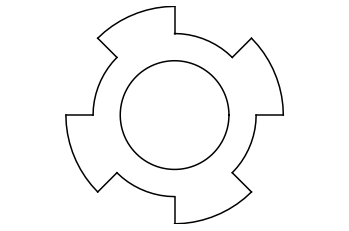

In [9]:
def plot_gear(T, R1, R2, R3, num, Bezier = True):
    """
    Plot the gear with `T` teeth, inner radius `R1`, outer radius `R2`,
    and intermediate radius `R3`, by sampling 10*`num` points on the
    inner circle, and `num` points on the remaining segments.
    """
    delta_u = 2*np.pi/(2*T)
    cc1 = circle_entire(R1, 10*num)
    
    if Bezier:
        c2 = Bezier_circle_segments(R2, T, num, 0)
        c3 = Bezier_circle_segments(R3, T, num, delta_u)
    else:
        c2 = circle_segments(R2, T, num, 0)
        c3 = circle_segments(R3, T, num, delta_u)
    
    a = np.linspace(0, delta_u, num = num)
    plt.plot(cc1[0,0:10*num].tolist()[0], cc1[0,10*num:20*num].tolist()[0], \
             linewidth=1.5, linestyle="-", color='k')

    # Circle segments
    for i in range(T):
        xx = np.asarray(c2[i,0:a.shape[0]]).tolist()[0]
        yy = np.asarray(c2[i,a.shape[0]:(2*a.shape[0])]).tolist()[0]
        plt.plot(xx, yy, color='k', linewidth=1.5, linestyle="-")

        xx = np.asarray(c3[i,0:a.shape[0]]).tolist()[0]
        yy = np.asarray(c3[i,a.shape[0]:(2*a.shape[0])]).tolist()[0]
        plt.plot(xx, yy, color='k', linewidth=1.5, linestyle="-")

    # Line segments
    for i in range(2*T):
        plt.plot([R2*np.cos(i*delta_u), R3*np.cos(i*delta_u)],
                 [R2*np.sin(i*delta_u), R3*np.sin(i*delta_u)], color='k', linewidth=1.5, linestyle="-")

    plt.axis('equal')
    plt.axis('off')
    plt.axis([- R2, R2, - R2, R2])
    plt.show()

def plot_clustered_gear(L_segments, L_segment_labels):
    """
    Given a list `L_segments` of segmented matrices by inferred degree
    and corresponding list `L_segment_labels` of segment labels by
    inferred degree, plot the gear for which the segments are colored
    according to the final clusters.
    """
    for j in range(len(L_segments)):
        segments = L_segments[j]
        segment_labels = L_segment_labels[j]
        
        for jj in range(len(segments)):
            segment_labels[jj]=segment_labels[jj]+j*L_segment_labels[0][-1]
                
        clusters   = list(set(segment_labels))
        n_clusters = len(clusters)

        for i in range(segments.shape[0]):
            col = mcolors.hsv_to_rgb(((segment_labels[i]+j*0.3)/segment_labels[len(segment_labels)-1], 
                                      0.5 + 0.5*segment_labels[i]/segment_labels[len(segment_labels)-1], 
                                      0.5 + 0.5*segment_labels[i]/segment_labels[len(segment_labels)-1]))

            # Hack: Treat the case i = 0 separately, to have a better plot of the center circle.
            if j == 1 and i == 0:
                segment = np.array(circle_entire(R1, 10*ns))
                plt.plot(segment[0,:10*ns], segment[0,10*ns:20*ns], color = 'grey')            
            else:
                plt.plot(np.array(segments[i,:ns])[0], np.array(segments[i,ns:2*ns])[0], color = col)

    plt.axis('off')
    plt.axis('scaled')
    plt.axis([- R2, R2, - R2, R2])
    plt.show()

plot_gear(T, R1, R2, R3, 10, Bezier = True)

### Timing the individual components of the algorithm
To see how the total CPU time breaks down, we time the individual components of the algorithm.

In [10]:
teeth_per_test = [4,8,16,32,64,128,256,512,1024]
assembling_times =[]
clustering_times = []
total_times =[]

for T in teeth_per_test:
    print("\n # teeth =", T)
    L_segments = segments_ordered(T, R1, R2, R3, ns)
    L_n = [segments.shape[0] for segments in L_segments]


    L_SSV = []
    L_segment_labels_history = []
    
    assembling_time = 0
    clustering_time = 0
    total_time = 0
    
    for d in range(1,d_max+1):
        
        t0 = time.time()
        SSV, segment_labels_history, t1, t2 = clustering_by_degree(L_segments[d-1], ns, d, verbose = True)
        L_SSV.append(SSV)
        L_segment_labels_history.append(segment_labels_history)
        t3 = time.time() - t0
        print("The clustering procedure for the segments of degree", d, "takes", t3,"seconds")
        
        assembling_time = assembling_time + t1
        clustering_time = clustering_time + t2
        total_time = total_time + t3
        
    assembling_times = assembling_times + [assembling_time]
    clustering_times = clustering_times + [clustering_time]
    total_times = total_times + [total_time]
        


 # teeth = 4
Assembling the segment dissimilarity_matrix took 0.002795696258544922 seconds
The remaining successive clustering took 0.0008232593536376953 seconds:
finding the minimum costs  0.00016999244689941406 seconds
finding the row and column indices  6.67572021484375e-05 seconds
update the dissimilarity matrix costs 0.00037169456481933594 seconds
The clustering procedure for the segments of degree 1 takes 0.0040607452392578125 seconds
Assembling the segment dissimilarity_matrix took 0.0038521289825439453 seconds
The remaining successive clustering took 0.0008029937744140625 seconds:
finding the minimum costs  8.392333984375e-05 seconds
finding the row and column indices  6.866455078125e-05 seconds
update the dissimilarity matrix costs 0.0004279613494873047 seconds
The clustering procedure for the segments of degree 2 takes 0.005256175994873047 seconds

 # teeth = 8
Assembling the segment dissimilarity_matrix took 0.008901119232177734 seconds
The remaining successive clustering t

In [11]:
L_timings = []
for i in range(len(teeth_per_test)):
    L_timings.append( (teeth_per_test[i], assembling_times[i], 
                       clustering_times[i], total_times[i]))
    

print("   T |  #segments |  CPU time a |  log_2(factor) a |  CPU time b |  log_2(factor) b |  CPU time c |  log_2(factor) c")
print("-----+------------+-------------+------------------+-------------+------------------+-------------+------------------")
t1_0 = 0
t2_0 = 0
t3_0 = 0
for T1, t1, t2, t3 in L_timings:
    s1a = '%.2f' % t1
    s2a = '%.2f' % t2
    s3a = '%.2f' % t3
    if t1_0 == 0:
        s1b = ""
    if t2_0 == 0:
        s2b = ""
    if t3_0 == 0:
        s3b = ""
    else:
        s1b = '%.2f' % (np.log(np.float64(t1)/t1_0)/np.log(2))
        s2b = '%.2f' % (np.log(np.float64(t2)/t2_0)/np.log(2))
        s3b = '%.2f' % (np.log(np.float64(t3)/t3_0)/np.log(2))
    print(( 4 - len(str(T1    )))*" " + str(T1    ) + " |" + \
          (11 - len(str(4*T1+1)))*" " + str(4*T1+1) + " |" + \
          (12 - len(s1a         ))*" " + s1a          + " |" + \
          (17 - len(s1b         ))*" " + s1b          + " |" + \
          (12 - len(s2a         ))*" " + s2a          + " |" + \
          (17 - len(s2b         ))*" " + s2b          + " |" + \
          (12 - len(s3a         ))*" " + s3a          + " |" + \
          ( 17 - len(s3b         ))*" " + s3b          )
          
    t1_0, t2_0, t3_0 = t1, t2, t3

   T |  #segments |  CPU time a |  log_2(factor) a |  CPU time b |  log_2(factor) b |  CPU time c |  log_2(factor)
-----+------------+-------------+------------------+-------------+------------------+-------------+------------------
   4 |         17 |        0.01 |                  |        0.00 |                  |        0.01 |                 
   8 |         33 |        0.02 |             1.65 |        0.00 |             1.02 |        0.03 |             1.45
  16 |         65 |        0.07 |             1.71 |        0.01 |             1.29 |        0.08 |             1.61
  32 |        129 |        0.26 |             1.94 |        0.04 |             2.40 |        0.31 |             1.98
  64 |        257 |        1.05 |             2.01 |        0.11 |             1.36 |        1.16 |             1.93
 128 |        513 |        4.06 |             1.95 |        0.44 |             1.99 |        4.50 |             1.95
 256 |       1025 |       14.56 |             1.84 |        2.01 

### Timing and images
We investigate the correctness and computational complexity of the algorithm, by applying it to the 2D gear example with $2^n, n = 0, 1, ...$ teeth, corresponding to $1 + 4\cdot 2^n$ segments.

Clustering of the gear with 2 teeth takes 0.002946615219116211 seconds.


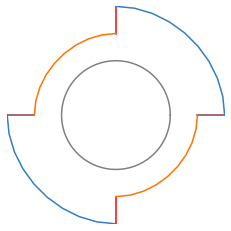

Clustering of the gear with 4 teeth takes 0.006372928619384766 seconds.


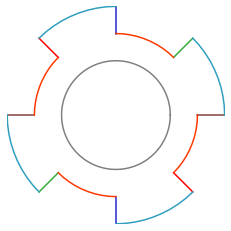

Clustering of the gear with 8 teeth takes 0.020414113998413086 seconds.


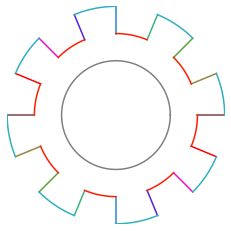

Clustering of the gear with 16 teeth takes 0.07343506813049316 seconds.


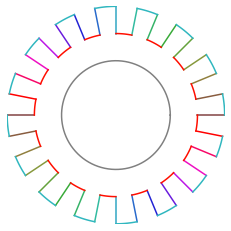

Clustering of the gear with 32 teeth takes 0.27303314208984375 seconds.


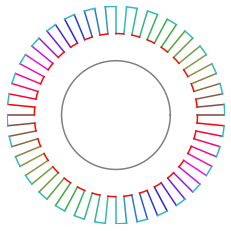

In [12]:
def apply_clustering(L_segments):
    L_SSV = []
    L_segment_labels_history = []
    Labeled_segments = []
    for d in range(1, d_max+1):
        SSV, segment_labels_history, assembling_time, clustering_time = clustering_by_degree(L_segments[d-1], ns, d)
        L_SSV.append(SSV)
        increment_SSV = [SSV[0]]
        for i in range(1, len(SSV)):
            increment_SSV.append(SSV[i] / SSV[i-1])
        L_segment_labels_history.append(segment_labels_history)
        increment_SSV.index(max(increment_SSV))        
        Labeled_segments.append(segment_labels_history[increment_SSV.index(max(increment_SSV))])
    return L_SSV, Labeled_segments


L_timings = []
for T in [2,4,8,16,32]:
    L_segments = segments_ordered(T, R1, R2, R3, ns)
    
    # We time the clustering procedure, using the best out of 10 runs
    t1 = math.inf
    for i in range(1):
        t0 = time.time()
        L_SSV, Labeled_segments = apply_clustering(L_segments)
        t1 = min(t1, time.time() - t0)
    
    L_timings.append( (T, t1) )
    print("Clustering of the gear with",T,"teeth takes",t1,"seconds.")

    #Select the segment labels of the final step of the clustering algorithm
    L_segment_labels = [Labeled_segments[0].tolist()[0], Labeled_segments[1].tolist()[0]]
    plot_clustered_gear(L_segments, L_segment_labels)